In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-folder/Cleaned_Nepali_dataset.csv
/kaggle/input/bert-folder/raw_dataset/raw_dataset/dataset_dict.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/state.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/dataset_info.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/data-00000-of-00001.arrow
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/state.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/dataset_info.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/data-00000-of-00001.arrow


## Checking pre-requistives for TPU

removing tensorflow to avoid conflicts with torch

In [2]:
!pip install --upgrade pip
!pip install ipywidgets --upgrade
!pip install datasets
!pip install tqdm
!pip uninstall tensorflow -y
!pip uninstall keras -y
!pip install tf-keras  # To satisfy transformers' internal requirement for now

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 39.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


## distilbert-base-nepali

In [3]:
# Loading dataset
path= '../input/bert-folder/Cleaned_Nepali_dataset.csv'
df= pd.read_csv(path)
df.head()

,Text,Target
0,गुठी विधेक ल्याएर ठमेल राज गुठि जग्गा छाया सेन...,0
1,दले देश सकेछन बेचे खान सुरू गरेछन दले लखेटनु पछ ।,1
2,नेपाल ससकृती ध्वस्त पार्ने योजना !,1
3,मठ मन्दिर गुम्बा जग्गा हरु भुमाफिया नजर परे हु...,1
4,नेपाल कल कर्खाना नदि नाला बेची सके मठ मन्दीर ब...,1


In [4]:
df.loc[:,"Target"].value_counts()

Target
1    1358
0     901
2     250
5     159
4     108
3      83
Name: count, dtype: int64

In [5]:
# Mapping to represent only the Sentiment Class
def map_target(value):
    if value in [0, 1]:
        return 0 # GENERAL
    elif value in [2]:
        return 1 # PROFANITY_0
    elif value in [3]:
        return 2 # PROFANITY_1
    elif value in [4, 5]:
        return 3 # VOILENCE

df_new = df.copy()
df_new['Target'] = df_new['Target'].apply(map_target)
df_new.loc[:, "Target"].value_counts()

Target
0    2259
3     267
1     250
2      83
Name: count, dtype: int64

In [6]:
label_map = {
    0: "GENERAL",
    1: "PROFANITY_0",
    2: "PROFANITY_1",
    3: "VOILENCE"
}

# Train-Test split
from sklearn.model_selection import train_test_split

X= df_new['Text']
y= df_new['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66, stratify=y)

print(y_train.value_counts())
print(y_test.value_counts())

Target
0    1807
3     214
1     200
2      66
Name: count, dtype: int64
Target
0    452
3     53
1     50
2     17
Name: count, dtype: int64


In [7]:
print(X_train.head())
print(y_train.head())

1473        रबि ब्यक्ति हैन रबि युग , जय रबि जय नेपाल , ।
1654             यत्ती पढेर जान्ने भन्नु बेकार पुन्य जी ।
2559    मेरय सायब ठिक यस्ता पित पत्रकार खातेलाइ नाक डा...
1786    जस जेसु कै भनोस लोकतन्त्र गणतन्त्र सर्बसाधारण ...
997       आज स्वगत प्रधानमन्त्रि सेर छोरो गब्बर सिह ... ।
Name: Text, dtype: object
1473    0
1654    0
2559    1
1786    0
997     0
Name: Target, dtype: int64


In [8]:
# Create train and test dataframe

train_df= pd.DataFrame()
train_df['Text']= X_train
train_df['Target']= y_train

test_df= pd.DataFrame()
test_df['Text']= X_test
test_df['Target']= y_test

from datasets import Dataset, DatasetDict
import pandas as pd

# Ensure the column names match Hugging Face expectations
train_df = train_df.rename(columns={"Target": "labels", "Text": "text"})
test_df = test_df.rename(columns={"Target": "labels", "Text": "text"})

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Create DatasetDict with train and validation datasets
raw_dataset = DatasetDict({
    "train": train_dataset.remove_columns("__index_level_0__"),  # Remove auto-generated index
    "validation": test_dataset.remove_columns("__index_level_0__")
})

# Print dataset details to verify
print(raw_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2287
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 572
    })
})


In [9]:
from datasets import Dataset

# Convert Pandas DataFrame to Hugging Face Dataset
train_df = Dataset.from_pandas(train_df)
test_df = Dataset.from_pandas(test_df)

## Tokenization

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name= "Sakonii/distilbert-base-nepali"

tokenizer= AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [11]:
# Generating Embeddings
def preprocess_function(document):
    return tokenizer(document["text"], truncation=True, padding='max_length')

train_tokenized= train_df.map(preprocess_function, batched= False,remove_columns=["text", "__index_level_0__"])
test_tokenized= test_df.map(preprocess_function, batched= False,remove_columns=["text", "__index_level_0__"])

# Convert to DataFrame and reorder columns
train_df2 = pd.DataFrame(train_tokenized)
train_df2 = train_df2[['input_ids', 'attention_mask', 'labels']]  # Set the correct order

# Convert back to Dataset
train_tokenized = Dataset.from_pandas(train_df2)
train_tokenized = train_tokenized.with_format("torch", columns=["input_ids", "attention_mask", "labels"])

test_df2 = pd.DataFrame(test_tokenized)
test_df2 = test_df2[['input_ids', 'attention_mask', 'labels']]  # Set the correct order

# Convert back to Dataset
test_tokenized = Dataset.from_pandas(test_df2)
test_tokenized = test_tokenized.with_format("torch", columns=["input_ids", "attention_mask", "labels"])



print(test_tokenized.features.keys())

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [13]:
sample_data = train_tokenized.select(range(5))
sample_data= sample_data.to_pandas()
sample_data.head()

,input_ids,attention_mask,labels
0,"[0, 9, 749, 4150, 2176, 9, 749, 2460, 10, 7, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,"[0, 19533, 6265, 10207, 2173, 18549, 1443, 744...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",0
2,"[0, 1030, 18, 119, 1126, 119, 220, 5536, 515, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,"[0, 1657, 750, 1188, 10, 96, 789, 18665, 2143,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,"[0, 136, 1311, 859, 19703, 10, 4733, 6796, 473...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


In [14]:
# Checking
tokenizer.decode(train_tokenized[0]["input_ids"])

'<s> रबि ब्यक्ति हैन रबि युग , जय रबि जय नेपाल , ।</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

- get api key from your account, this will download a kaggle.json file
- add your username and key to Add-ons/secrets

In [15]:

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# api_key = user_secrets.get_secret("api_key")
# user_name = user_secrets.get_secret("user_name")

# json_content = f'{{"username": "{user_name}", "key": "{api_key}"}}'

# # Write JSON content to kaggle.json
# with open('kaggle.json', 'w') as f:
#     f.write(json_content)

In [16]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


## Fine-tuning

In [17]:
# Evaluation Setup

from sklearn.metrics import classification_report


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    report = classification_report(y_true=labels, y_pred=predictions, output_dict=True)

    accuracy = report['accuracy']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    f1 = report['macro avg']['f1-score']
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

## Custom Loss function with class weights

In [18]:
from torch import nn
import torch
from sklearn.utils.class_weight import compute_class_weight

# Number of classes
num_labels = 4

# obtaining class weight with compute_class_weight
class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
class_weights = class_weights / np.sum(class_weights)  # Normalizing magnitude for proper gradient updates

# Convert class weights to a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print(class_weights)

# Custom loss function
def compute_loss_func(outputs, labels, num_items_in_batch=None):
    logits = outputs.logits
    weights = class_weights.to(logits.device)
    loss_fct = nn.CrossEntropyLoss(weight=weights)
    loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
    return loss


tensor([0.0218, 0.1970, 0.5970, 0.1841])


In [19]:
# wandb for logging, get the login key from wandb.ai/authorize
!pip install wandb
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_secret = user_secrets.get_secret("wandb")
wandb.login(key=wandb_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tamangangel2057 (tamangangel2057-student). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [20]:
# Load pre-trained Model
model= AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
model.train()

config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [21]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import load_from_disk

output_dir = "/kaggle/working/BERT_Classifier_v1"
run_name= "BERT_v1"

args = TrainingArguments(
    output_dir=output_dir,
    run_name=run_name,
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    warmup_ratio= 0.1,
    save_strategy="epoch",
    save_on_each_node=True,
    learning_rate=1e-5,
    num_train_epochs=15,
    weight_decay=0.01,
    report_to="wandb",
    push_to_hub=False,
    save_total_limit= 1,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    greater_is_better=True,
    overwrite_output_dir= True,
    bf16=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
    compute_loss_func=compute_loss_func, # Loss function with weights
    callbacks = [EarlyStoppingCallback(early_stopping_patience=4, early_stopping_threshold=0.005,)]
)
trainer.train()

trainer.save_model("/kaggle/working/")
tokenizer.save_pretrained("/kaggle/working/")



Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.380996,0.562937,0.289189,0.267624,0.264031
2,No log,1.337867,0.589161,0.393582,0.361670,0.339266
3,No log,1.275531,0.571678,0.444125,0.580898,0.377753
4,No log,1.195740,0.620629,0.496036,0.450075,0.414948
5,No log,1.123613,0.641608,0.545132,0.440178,0.452763
6,No log,1.054526,0.671329,0.584464,0.446364,0.480362
7,No log,1.016776,0.643357,0.563436,0.478588,0.477755
8,No log,0.966398,0.667832,0.629697,0.455611,0.495120
9,No log,0.978390,0.720280,0.628823,0.513620,0.548197
10,No log,0.945628,0.702797,0.623009,0.488148,0.525692


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/tokenizer.json')

We have to define a _mp_fn function which will be called with the index of the TPU core that it will run on.

In order to diminish TPU memory usage, we use the WRAPPED_MODEL defined before.

Then, we call xmp.spawn with start_method='fork'.

In [ ]:
trainer.evaluate()

In [22]:
wandb.finish() # Only finish after evaluating

eval/accuracy,▁▂▁▃▄▆▄▆█▇█▇█
eval/f1,▁▃▄▅▆▆▆▇█▇▇▇▇
eval/loss,█▇▆▅▄▃▂▁▂▁▁▁▁
eval/precision,▁▃█▅▅▅▆▅▆▆▆▆▆
eval/recall,▁▃▄▅▆▇▇███▇██
eval/runtime,▁█▅▄▅▄▄▅▄▄▄▅▄
eval/samples_per_second,█▁▄▅▄▅▅▄▄▅▄▄▄
eval/steps_per_second,█▁▄▅▄▅▅▄▄▅▄▄▄
train/epoch,▁▂▂▃▃▄▅▅▆▆▇▇██
train/global_step,▁▂▂▃▃▄▅▅▆▆▇▇██
eval/accuracy,0.72028


In [23]:
# import torch_xla.core.xla_model as xm
# import torch_xla as xla
# import torch_xla.distributed.xla_backend
# import torch.distributed as dist
# import torch_xla.distributed.xla_multiprocessing as xmp

# # Load pre-trained Model
# model= AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
# model.train()

# # Wrapping model for TPU usage
# WRAPPED_MODEL = xmp.MpModelWrapper(model)

# def _mp_fn(index):
#     # Initialize XLA distributed process group
#     dist.init_process_group("xla", init_method='xla://')

#     # Get TPU
#     device = xm.xla_device()
#     model =WRAPPED_MODEL.to(device)

#     train_func(model)
    
# xla.launch(_mp_fn, args=(), start_method='fork')

## Evaluation

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       452
           1       0.27      0.56      0.36        50
           2       0.48      0.65      0.55        17
           3       0.37      0.55      0.44        53

    accuracy                           0.72       572
   macro avg       0.51      0.63      0.55       572
weighted avg       0.82      0.72      0.75       572



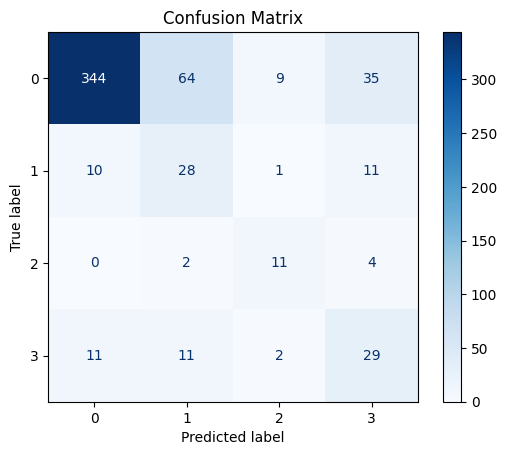

In [25]:
wandb.init()
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# # Load the test dataset
# test_dataset = load_from_disk("/kaggle/working/test_tokenized")

predictions = trainer.predict(test_tokenized)
final_predictions = np.argmax(predictions.predictions, axis=1)

label_map = {
    0: 'GENERAL',
    1: 'PROFANITY_0',
    2: 'PROFANITY_1',
    3: 'VIOLENCE'
}

prediction_data = []
for gt, pt in zip(test_tokenized['labels'], final_predictions):
    prediction_data.append([gt, pt])
    
prediction_df = pd.DataFrame(prediction_data, columns=['labels', 'predictions'])
# Convert tensor labels to integers
prediction_df['labels'] = prediction_df['labels'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

report = classification_report(y_true=prediction_df['labels'], y_pred=prediction_df['predictions'])
print(report)

# Confusion matrix
cm = confusion_matrix(y_true= prediction_df['labels'], y_pred= prediction_df['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(prediction_df['labels']))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [30]:
from huggingface_hub import notebook_login
notebook_login()

In [31]:
# Saving the best model to hub
trainer.save_model("best_model")
trainer.push_to_hub("Vyke2000/BERT_v1")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Vyke2000/BERT_Classifier_v1/commit/5a97cf7cd3fe5cdea144482e96354daa4046d0cd', commit_message='Vyke2000/BERT_v1', commit_description='', oid='5a97cf7cd3fe5cdea144482e96354daa4046d0cd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Vyke2000/BERT_Classifier_v1', endpoint='https://huggingface.co', repo_type='model', repo_id='Vyke2000/BERT_Classifier_v1'), pr_revision=None, pr_num=None)